In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of tickers to be downloaded
# You can uncomment the set of tickers you are interested in

tickers = tickers_bond = ['IEF', 'SHY', 'TIP', 'TLT', 'HYG', 'LQD', 'AGG', 'BND', 'EMB', 'MUB', 'PFF', '^GSPC', 'TIP', '^GSPC', 'LQD', 'UDN', 'EURUSD=X', '^VIX', 'CL=F', '^IRX', '^FVX', '^TNX', '^TYX']
#tickers = tickers_como = ['HG=F', 'CL=F', 'BZ=F', 'NG=F', 'RB=F', 'HO=F', 'CC=F', 'ZW=F', 'ZC=F', 'ZS=F', '^VIX', 'CT=F', 'CC', 'KC', 'SB', 'GF=F', 'GC=F', 'SI=F', 'PL=F', 'PA=F', 'ZN=F', 'ZB=F']

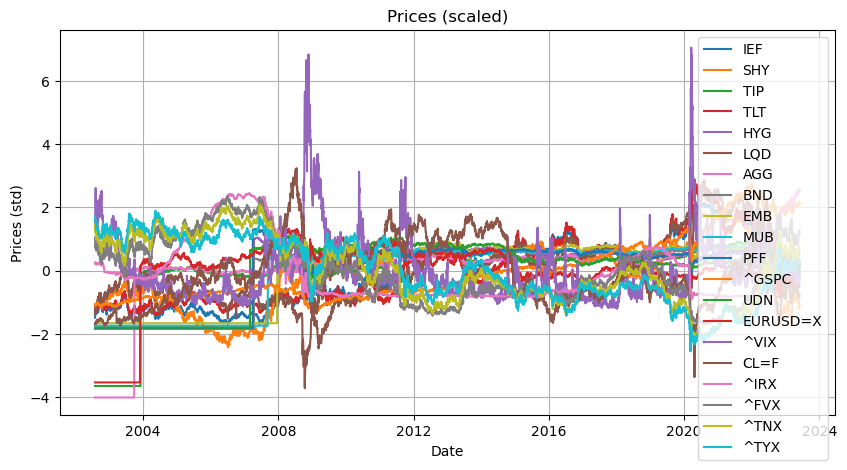

In [3]:
from basic_finance_tools import get_or_download_data, plot_df

# Specify the date range for data download
start = '2000-06-01'
end = '2023-06-01'

prices_data = get_or_download_data(tickers, start_date = start, end_date = end).ffill().fillna(0)

plot_df(prices_data, title= 'Prices', unit='USD', scaled=True)

In [4]:
from OptimalLinearSignal import *
from sklearn.preprocessing import StandardScaler

def compute_signal_OLS(pivot: pd.DataFrame, X: pd.DataFrame, 
                           training_size: int = 10, k_components:int=0, 
                           l2_reg:float=1, l1_reg:float=0, p_val:float=0.001,)->pd.DataFrame:
    
    signal = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    
    for index_ticker, ticker in enumerate(pivot.columns):
        model = OptimalLinearSignal(pivot[ticker].diff(), l2_reg, l1_reg, k_principal_components=k_components, p_value_threshold=p_val)
        scaler = StandardScaler()
        
        # Initialize DataFrame for predicted prices
        signal.iloc[:training_size, index_ticker] = np.nan  # Filling with NaN
        
        # Perform online training and prediction
        for p in range(1, len(pivot) // training_size):
            index_day = p * training_size
            X_train = X.iloc[index_day - training_size: index_day-1, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            #model.make_beta_neutral(pivot[ticker])
            model.fit(X_train_scaled)
            
            X_day = X.iloc[index_day : index_day + training_size, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_scaled = pd.DataFrame(scaler.transform(X_day), columns=X_day.columns, index=X_day.index)

            predicted_signal = model.predict(X_scaled)
            corrective_term = np.sign(model.correct(X_scaled))
            signal.iloc[index_day : index_day + training_size, index_ticker] = predicted_signal.values * corrective_term.values
            
    return signal.ffill()

In [5]:
from basic_finance_tools import compute_position, compute_PNL, compute_metrics, plot_ds_hue, plot_df

def show_strat_OLS(prices: pd.DataFrame, X: pd.DataFrame, ts: int, k:int, l2:float, l1:float=0, pvt:float=0.001):
    """
    Demonstrates a trading strategy based on OLS and visualizes the results.
    """

    pivot = prices[[prices_data.columns[0]]]
    try: signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, l2_reg=l2, l1_reg=l1, p_val=pvt)
    except ValueError: #When the model raise error for Matrix not invertible
        print('No signal')
        return 

    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    print(compute_metrics(pnl, positions))
    plot_ds_hue(pnl['DAILY'], pd.Series(signal.abs().mean(axis=1), index=signal.index), 
                title="PNL", #period=['2019-06-01', '2022-06-01']
                )
        
    #plot_df(pd.DataFrame({'Positions (abs)': 25 * 1000 * positions.abs().sum(axis=1) / pnl['DAILY'].std(), 'Cumulative PnL': 25 * 1000 * pnl['DAILY'].cumsum() / pnl['DAILY'].std(),}), title='Position vs PnL', unit='USD (scaled on: 25kUSD / std risk)')

In [6]:
X = pd.concat([prices_data.copy(),
               pd.DataFrame(prices_data.diff(), index=prices_data.index, columns=[str(col)+'.diff' for col in prices_data.columns]),
               pd.DataFrame(prices_data.pct_change(), index=prices_data.index, columns=[str(col)+'.pct_change' for col in prices_data.columns]),
    ], axis=1)

prices = prices_data


{'sharpe_ratio': 0.5, 'turnover': 35.3, 'bips': 11.9, 'effective_sharpe_ratio': 1.07, 'eff_turnover': 162.2}


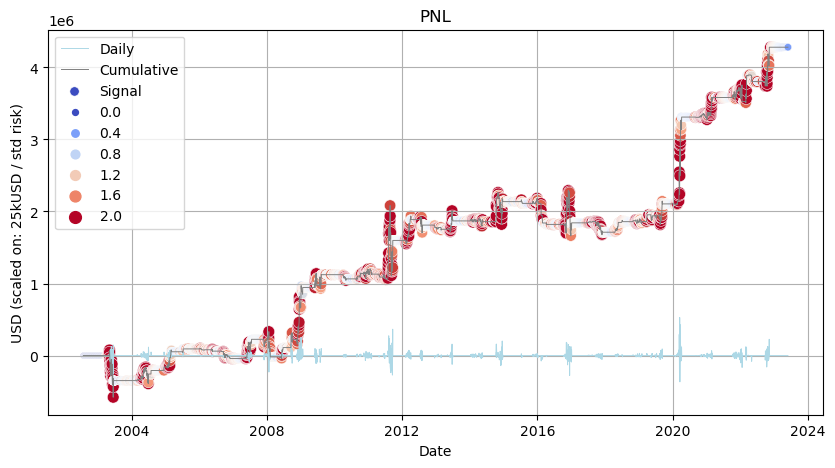

{'sharpe_ratio': 0.58, 'turnover': 35.6, 'bips': 14.4, 'effective_sharpe_ratio': 1.33, 'eff_turnover': 184.12}


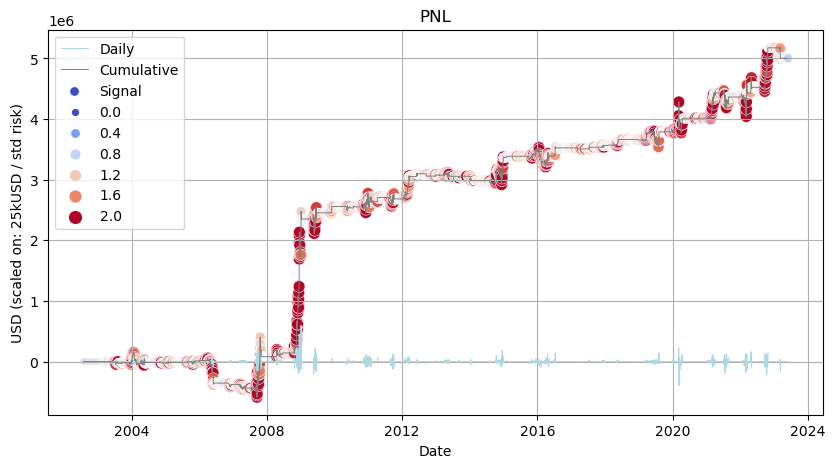

In [7]:
show_strat_OLS(prices, X, ts=77, k=6, l2=1,)
show_strat_OLS(prices, X, ts=60, k=35, l2 = 10, l1=0.1,)

# 3 different trajectory of the PnL using 2 different parameters set

In [8]:
# Grid search optimization for wz1, wz2, wvt parameters for zscore strat
from basic_finance_tools import axial_grid_search, grid_search

def evaluate_OLS_strat(ts: int, k:int = 1, l2:float=1, l1:float=0, pvt:float=0.001, metric:str='sharpe_ratio') -> float:

    global prices, X
    
    pivot = prices[[prices.columns[0]]]
    try: signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, l2_reg=l2, l1_reg=l1, p_val=pvt)
    except ValueError: return 0 
    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    return compute_metrics(pnl, positions)[metric]

# Define parameter ranges for grid search
param_grid = {
    'ts': np.linspace(55, 200, 20, dtype=int).tolist(),
    'k': [0, 1, 3, 5,] + np.linspace(6, len(X.columns)-1, 6, dtype=int).tolist(),
    'l2': [0.1],# 10, 0, 0.1, 0.5, 1, ],
    'l1': [0],
    'pvt': [0.001, 0.01, 0.1, 0.4,]

} # Note that there is just a few params for each 'ts'

best_param_values, _ = axial_grid_search(evaluate_OLS_strat, param_dict=param_grid, param_selected='ts')

for params in best_param_values: show_strat_OLS(prices, X, **params)  

1 / 20 2 / 20 3 / 20 4 / 20 5 / 20 6 / 20 7 / 20 8 / 20 9 / 20 